In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
#from keras.layers import Concatenate

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/MyDrive')


Mounted at /MyDrive


In [3]:
df = pd.read_pickle("/MyDrive/MyDrive/DataScience/even_class.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12784 entries, 0 to 12783
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     12784 non-null  object
 1   img_data  12784 non-null  object
dtypes: object(2)
memory usage: 199.9+ KB


In [4]:
df['label'].value_counts()

basophil        1598
neutrophil      1598
monocyte        1598
lymphocyte      1598
platelet        1598
eosinophil      1598
ig              1598
erythroblast    1598
Name: label, dtype: int64

In [13]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df.label)
df['label'].value_counts()

0    1598
6    1598
5    1598
4    1598
7    1598
1    1598
3    1598
2    1598
Name: label, dtype: int64

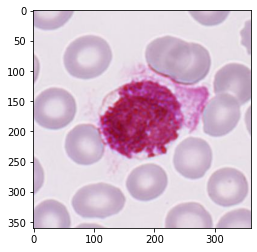

In [14]:
#Dispaly an img_data
plt.imshow(df['img_data'].iloc[600])

In [15]:
# Shuffle the DataFrame, and split into train, validation and test sets

shuffled_df = df.sample(frac=1)


In [16]:
data = df.img_data
target = df.label

#train test split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2)

#train validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2)


In [17]:

print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_test), len(y_test))

8181 8181
2046 2046
2557 2557


In [18]:
X_train = np.stack(X_train, axis=0)
X_val = np.stack(X_val, axis=0)
X_test = np.stack(X_test, axis=0)

In [19]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [32]:
#augmentation layer

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2), 
    #layers.experimental.preprocessing.Rescaling(1./255),
    #layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
    #layers.experimental.preprocessing.RandomTranslation(0.3, 0.3)
    ])

In [33]:
# Define the Model

def create_model(n_labels, fine_tune = 0):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(360, 360, 3))
    
    if fine_tune > 0:
        for layer in base_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in base_model.layers:
            layer.trainable = False
            
    inputs    = Input(shape=(360, 360, 3))
    rescale   = preprocess_input(inputs)
    augmented = data_augmentation(rescale)
    vgg16     = base_model(augmented)
    pooling   = layers.GlobalAveragePooling2D()(vgg16)
    dense1    = Dense(4096, activation='relu')(pooling)
    dense2    = Dense(1072, activation='relu')(dense1)
    dropout   = Dropout(0.2)(dense2)
    outputs   = Dense(n_labels, activation='softmax')(dropout)
    model     = Model(inputs=inputs, outputs=outputs)

    return model

In [34]:
model = create_model(len(df['label'].unique()))
model.summary()

optimizer = Adam(learning_rate=0.001)

# Compiles the model for training.
model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 360, 360, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 360, 360, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 360, 360, 3)      0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 360, 360, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0   

In [35]:
history = model.fit(x= X_train, y=y_train,
                    epochs = 10, 
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10


256/256 [==============================] - 26s 92ms/step - loss: 1.2910 - accuracy: 0.6249 - val_loss: 0.5521 - val_accuracy: 0.8074
Epoch 2/10
256/256 [==============================] - 22s 88ms/step - loss: 0.5975 - accuracy: 0.7878 - val_loss: 0.4586 - val_accuracy: 0.8358
Epoch 3/10
256/256 [==============================] - 22s 88ms/step - loss: 0.4880 - accuracy: 0.8339 - val_loss: 0.4270 - val_accuracy: 0.8446
Epoch 4/10
256/256 [==============================] - 22s 88ms/step - loss: 0.4195 - accuracy: 0.8560 - val_loss: 0.3713 - val_accuracy: 0.8700
Epoch 5/10
256/256 [==============================] - 22s 88ms/step - loss: 0.4226 - accuracy: 0.8522 - val_loss: 0.5248 - val_accuracy: 0.8084
Epoch 6/10
256/256 [==============================] - 23s 89ms/step - loss: 0.3688 - accuracy: 0.8688 - val_loss: 0.3378 - val_accuracy: 0.8773
Epoch 7/10
256/256 [==============================] - 22s 88ms/step - loss: 0.3534 - accuracy: 0.8747 - val_loss: 0.3783 - val_accuracy: 0.8612
Epo

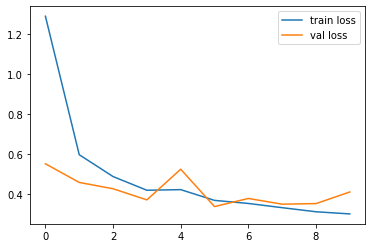

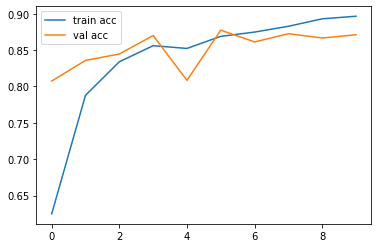

In [36]:

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [37]:
# Generate predictions

from sklearn.metrics import accuracy_score, f1_score

predicted = model.predict(X_test)                        # predicted values or probabilities?
predicted_classes = np.argmax(predicted, axis=-1)        # predicted classes

true_classes = np.argmax(y_test, axis=-1)                # equal to y_test

acc_score = accuracy_score(true_classes, predicted_classes)
f1_score = f1_score(true_classes, predicted_classes, average="weighted")

print(f"Model Accuracy without Fine-Tuning: {round(acc_score * 100, 2)}")
print(f"Model F1 Score without Fine-Tuning: {round(f1_score * 100, 2)}")

80/80 [==============================] - 3s 34ms/step
Model Accuracy without Fine-Tuning: 84.87
Model F1 Score without Fine-Tuning: 84.85


In [38]:
#classification report
from sklearn import metrics
print(metrics.classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       334
           1       0.75      0.93      0.83       318
           2       0.95      0.84      0.89       320
           3       0.84      0.86      0.85       331
           4       0.68      0.94      0.79       306
           5       0.90      0.64      0.75       316
           6       0.91      0.82      0.86       310
           7       0.91      1.00      0.95       322

    accuracy                           0.85      2557
   macro avg       0.87      0.85      0.85      2557
weighted avg       0.87      0.85      0.85      2557



[[258  26   4  25  13   4   1   3]
 [  1 295   1   2   8   0  11   0]
 [  0   3 269   6  24   0   0  18]
 [  1  16   4 286   9   9   3   3]
 [  0   5   2   1 287   5   4   2]
 [  1  30   0  14  61 201   7   2]
 [  2  18   3   5  22   4 253   3]
 [  0   1   0   0   0   0   0 321]]


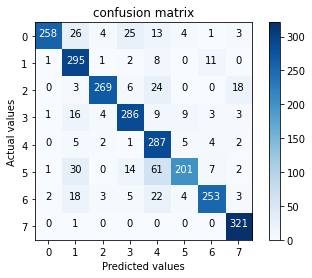

In [39]:
import itertools

cnf_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
print(cnf_matrix)
classes = range(0,8)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

In [46]:
# Fine Tuning

model = create_model(len(df['label'].unique()), 5)
model.summary()

optimizer = Adam(learning_rate=0.0001)

# Compiles the model for training.
model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 360, 360, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 360, 360, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 360, 360, 3)      0         
 a)                                                              
                                                                 
 sequential_1 (Sequential)   (None, 360, 360, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 11, 11, 512)       14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

In [47]:
history = model.fit(x= X_train, y=y_train,
                    epochs = 10, 
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10


256/256 [==============================] - 27s 95ms/step - loss: 0.6336 - accuracy: 0.7817 - val_loss: 0.2770 - val_accuracy: 0.9135
Epoch 2/10
256/256 [==============================] - 24s 92ms/step - loss: 0.2154 - accuracy: 0.9320 - val_loss: 0.2141 - val_accuracy: 0.9316
Epoch 3/10
256/256 [==============================] - 24s 92ms/step - loss: 0.1570 - accuracy: 0.9505 - val_loss: 0.1843 - val_accuracy: 0.9448
Epoch 4/10
256/256 [==============================] - 24s 93ms/step - loss: 0.1158 - accuracy: 0.9624 - val_loss: 0.3689 - val_accuracy: 0.9057
Epoch 5/10
256/256 [==============================] - 24s 92ms/step - loss: 0.1051 - accuracy: 0.9675 - val_loss: 0.1669 - val_accuracy: 0.9462
Epoch 6/10
256/256 [==============================] - 24s 92ms/step - loss: 0.0908 - accuracy: 0.9718 - val_loss: 0.1086 - val_accuracy: 0.9677
Epoch 7/10
256/256 [==============================] - 24s 92ms/step - loss: 0.0736 - accuracy: 0.9763 - val_loss: 0.1061 - val_accuracy: 0.9692
Epo

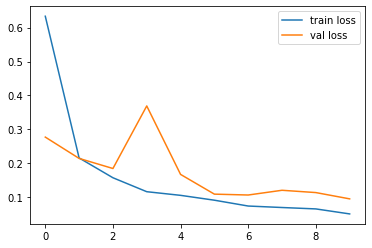

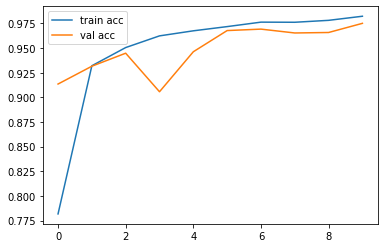

In [48]:

# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import accuracy_score, f1_score

predicted = model.predict(X_test)                        # predicted values or probabilities?
predicted_classes = np.argmax(predicted, axis=-1)        # predicted classes

true_classes = np.argmax(y_test, axis=-1)                # equal to y_test

acc_score = accuracy_score(true_classes, predicted_classes)
f1_score = f1_score(true_classes, predicted_classes, average="weighted")

print(f"Model Accuracy with Fine-Tuning: {round(acc_score * 100, 2)}")
print(f"Model F1 Score with Fine-Tuning: {round(f1_score * 100, 2)}")

80/80 [==============================] - 3s 34ms/step
Model Accuracy with Fine-Tuning: 96.25
Model F1 Score with Fine-Tuning: 96.24


In [50]:
#classification report
from sklearn import metrics
print(metrics.classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       334
           1       1.00      0.98      0.99       318
           2       0.97      0.99      0.98       320
           3       0.93      0.96      0.94       331
           4       0.97      0.91      0.94       306
           5       0.92      0.97      0.95       316
           6       0.97      0.91      0.94       310
           7       1.00      1.00      1.00       322

    accuracy                           0.96      2557
   macro avg       0.96      0.96      0.96      2557
weighted avg       0.96      0.96      0.96      2557



[[328   0   0   4   1   1   0   0]
 [  1 311   0   1   1   0   4   0]
 [  0   0 316   2   1   1   0   0]
 [  3   0   2 317   2   7   0   0]
 [  4   0   5   1 279  14   3   0]
 [  1   0   0   4   3 307   1   0]
 [ 11   1   3  11   1   2 281   0]
 [  0   0   0   0   0   0   0 322]]


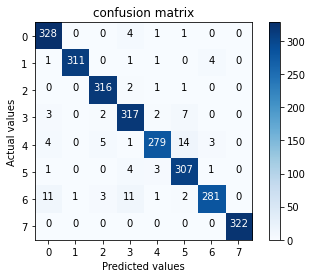

In [51]:
import itertools

cnf_matrix = metrics.confusion_matrix(true_classes, predicted_classes)
print(cnf_matrix)
classes = range(0,8)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

In [52]:
#Save model
from tensorflow.keras.models import save_model
save_model(model, "/MyDrive/MyDrive/DataScience/vgg16_augmented_model.h5")

In [53]:
#Displayed Actual values & Predicted values column wise
df_tested = pd.DataFrame(zip(true_classes, predicted_classes),
                  columns=['Actual Value', 'Predicted Value'])

predicted_classes_name = df_tested['Predicted Value'].map( {0:'basophil',
                                                            1: 'neutrophil',
                                                            2: 'monocyte',
                                                            3: 'lymphocyte',
                                                            4: 'platelet',
                                                            5: 'eosinophil',
                                                            6: 'ig',
                                                            7: 'erythroblast'}).astype(str)

df_tested['Predicted Class'] = predicted_classes_name
df_tested

,Actual Value,Predicted Value,Predicted Class
0,3,3,lymphocyte
1,7,7,erythroblast
2,4,4,platelet
3,6,6,ig
4,4,5,eosinophil
...,...,...,...
2552,3,3,lymphocyte
2553,4,4,platelet
2554,0,0,basophil
2555,6,6,ig
